***(i) Import the function from the module "mzprojection"***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mzprojection import mzprojection_multivariate, split_long_time_series, calc_correlation

#help(mzprojection_multivariate)

***(ii) Prepare ensemble of time series data***  
Here, we split a long time-series data of statistically steady state into some number of short-time ensembles.

t_raw[:].shape= (20000,)
u_raw[:,nu].shape= (20000, 18)
f_raw[:,nf].shape= (20000, 18) # nu/=nf is available.


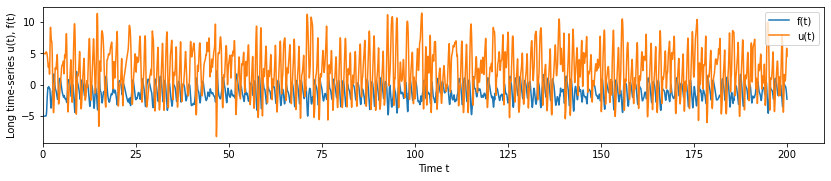

In [4]:
#= Read sample data =
ds = xr.open_dataset('../sample_data/sample_multivariate_L96xy.nc')
t_raw    = np.array(ds.t)      # Time t
u_raw    = np.array(ds.u).T    # Variable of interest u(t)
dudt_raw = np.array(ds.dudt).T # = du/dt
f_raw    = np.array(ds.f).T    # Analyzed data f(t)
print("t_raw[:].shape=",t_raw.shape)
print("u_raw[:,nu].shape=",u_raw.shape)
print("f_raw[:,nf].shape=",f_raw.shape,"# nu/=nf is available.")

fig = plt.figure(figsize=(14,2.5))
ax = fig.add_subplot(111)
ax.plot(t_raw,f_raw[:,0],label="f(t)")
ax.plot(t_raw,u_raw[:,0],label="u(t)")
ax.set_xlim(0,None)
ax.set_xlabel("Time t")
ax.set_ylabel("Long time-series u(t), f(t)")
plt.legend()
plt.show()

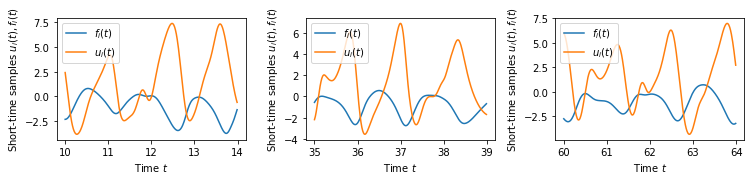

In [5]:
#= Split a long time series data into samples of short-time data =
ista    = 1000                # Start time step number for sampling   
nperiod = 400                 # Time step length of a short-time sample                 
nshift  = 10                   # Length of time shift while sampling
t   =split_long_time_series(t_raw,ista=ista,nperiod=nperiod,nshift=nshift)
u   =split_long_time_series(u_raw,ista=ista,nperiod=nperiod,nshift=nshift)
dudt=split_long_time_series(dudt_raw,ista=ista,nperiod=nperiod,nshift=nshift)
f   =split_long_time_series(f_raw,ista=ista,nperiod=nperiod,nshift=nshift)
dudt0 = dudt[:,0] # dudt0[nsample], dudt[nsample,nperiod] 

fig = plt.figure(figsize=(14,2.5))
samples = [0,250,500]
for i in range(len(samples)):
    ax = fig.add_subplot(int("14{:}".format(i+1)))
    isample = samples[i]
    ax.set_xlabel(r"Time $t$")
    ax.set_ylabel(r"Short-time samples $u_i(t), f_i(t)$")
    ax.plot(t[isample,:],f[isample,:,0],label=r"$f_i(t)$")
    ax.plot(t[isample,:],u[isample,:,0],label=r"$u_i(t)$")
    ax.legend()
fig.tight_layout()
plt.show()

***(iii) Apply the Moti-Zwanzig projection operator method***  
The projection of $f(t)^i$ on $u(t)^i$ is calculated as,  
    $f(t)=\Omega u(t)+s(t)+r(t)$,  
    $s(t)=-\int_0^t \Gamma(t) u(t-v)dv$.  
The Markov coefficient $\Omega$, the memory function $\Gamma(t)$ and the uncorrelated term $r(t)$ are obtained as outputs.  
(Some correlations, e.g., $\langle r(t) u \rangle$ are also obtained to check the result.)

In [14]:
delta_t = t_raw[1] - t_raw[0] # Time step size
omega, memoryf, s, r = mzprojection_multivariate(delta_t, u, dudt0, f, flag_terms=True, flag_debug=True)
t_cor = delta_t * np.arange(memoryf.shape[0])

nsample= 1861 , nperiod= 400 , nu= 18 , nf= 18
(1861, 400, 18) (1861, 18) (18, 18) (400, 18, 18) (18, 18)
# Prepare correlations [sec]: 0.03494668006896973
      uu0_inv[nu,nu].shape= (18, 18) float64
ududt[nperiod,nu,nu].shape= (400, 18, 18) float64
    G[nperiod,nu,nu].shape= (400, 18, 18) float64
      wG0_inv[nu,nu].shape= (18, 18) float64
# Calc. omega & memoryf [sec]: 0.18337345123291016
          omega[nf,nu].shape= (18, 18) float64
memoryf[nperiod,nf,nu].shape= (400, 18, 18) float64
# Prepare to calc. s & r [sec]: 0.08851313591003418
# Calc. memory term s [sec]: 2.394940137863159
# Calc. residual r [sec]: 0.48509788513183594
s[nsample,nperiod,nf].shape= (1861, 400, 18) float64
r[nsample,nperiod,nf].shape= (1861, 400, 18) float64


***(iv-a) Check results: plot $\Omega$ and $\Gamma(t)$***  

Markov coefficient matrix Omega =  -0.23643966439861028


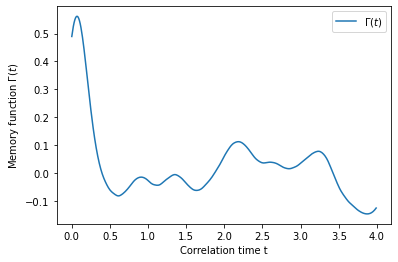

In [15]:
print("Markov coefficient matrix Omega = ", omega[0,0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel("Memory function $\Gamma(t)$")
ax.plot(t_cor,memoryf[:,0,0],label="$\Gamma(t)$")
plt.legend()
plt.show()

***(iv-b) Check results: plot time evolution of $f(t)=\Omega u(t)+s(t)+r(t)$***  

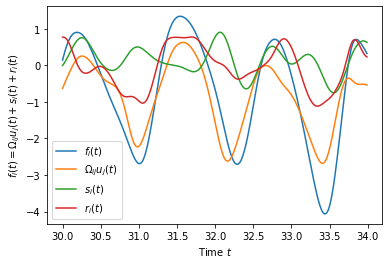

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"$f_i(t)=\Omega_{ij}u_j(t)+s_i(t)+r_i(t)$")
isample=200
ax.plot(t[isample,:],f[isample,:,0],label=r"$f_i(t)$")
ax.plot(t[isample,:],np.dot(u[isample,:,:],omega.T)[:,0].real,label=r"$\Omega_{ij}u_j(t)$")
ax.plot(t[isample,:],s[isample,:,0],label=r"$s_i(t)$")
ax.plot(t[isample,:],r[isample,:,0],label=r"$r_i(t)$")
plt.legend()
plt.show()

***(iv-c) Check results: Extended generalized fluctuation-dissipation theorem $\Gamma(t) = \langle r(t) du/dt \rangle / \langle u u \rangle$***  

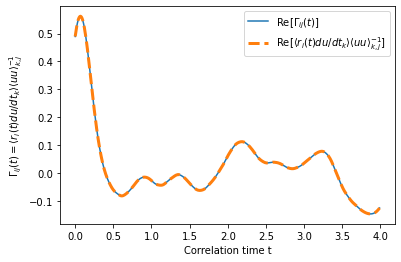

In [31]:
u0 = u[:,0]
f0 = f[:,0]
r0 = r[:,0]
uu = calc_correlation(u,u0)
ududt = calc_correlation(u,dudt0)
ff = calc_correlation(f,f0)
fdudt = calc_correlation(f,dudt0)
fu = calc_correlation(f,u0)
rr = calc_correlation(r,r0)
rdudt = calc_correlation(r,dudt0)
ru = calc_correlation(r,u0)
uu0_inv = np.linalg.inv(uu[0,:,:])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel(r"$\Gamma_{ij}(t) = \langle r_i(t) du/dt_k \rangle \langle u u \rangle^{-1}_{k,j}$")
ax.plot(t_cor,memoryf[:,0,0],label="Re[$\Gamma_{ij}(t)$]")
ax.plot(t_cor,np.dot(rdudt,uu0_inv)[:,0,0],"--",label=r"Re[$\langle r_i(t) du/dt_k \rangle \langle u u \rangle^{-1}_{k,j}$]",lw=3)
plt.legend()
plt.show()

***(iv-d) Check results: $\langle r(t) u \rangle = 0$***  
Namely, the uncorrelated term $r(t)$ indeed extracts the part of $f(t)$ uncorrelated with $u$. It is checked by $\langle r(t) u \rangle \ll \langle f(t) u \rangle$.

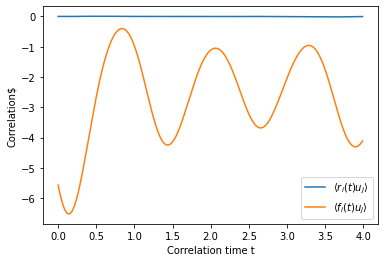

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel("Correlation$")
ax.plot(t_cor,ru[:,0,0],label=r"$\langle r_i(t) u_j \rangle$")
ax.plot(t_cor,fu[:,0,0],label=r"$\langle f_i(t) u_j \rangle$")
plt.legend()
plt.show()